In [1]:
import tensorpack as tp
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt

from helpers.rsr_run import Model
from helpers.rsr_run import create_dataflow
from helpers.rsr_run import net_fn_map
from helpers.rsr2015 import *
from tensorpack import *
from tensorpack.utils.gpu import get_nr_gpu
from tensorpack.tfutils.varmanip import *
import os
from datetime import datetime

%load_ext autoreload
%autoreload 1

def avg(w): return sum(w.flatten())/len(w.flatten())

def compute_nbits_for_maxval(inp, overflow_rate, verbose=False):
    sorted_vals = np.sort(np.abs(inp).flatten())[::-1]
    split_idx = int(overflow_rate * len(sorted_vals))
    v = sorted_vals[split_idx]
    if verbose: print("maxval:",v, "bits for maxval", math.log(v+1e-12, 2), "rounded bits for maxval", math.ceil(math.log(v+1e-12, 2)))
    return math.ceil(math.log(v+1e-12, 2))

def linear_quantize(v, w_bits, bits_per_delta):
    bound = math.pow(2.0, w_bits-1)
    min_val, max_val = - bound, bound - 1
    delta = math.pow(2.0, bits_per_delta)
    quantized = np.round(v / delta)
    clipped = np.clip(quantized, min_val, max_val)
    return clipped*delta

def quantize_var(v, n_bits, overflow_rate=0.01, bits_per_delta=None, verbose=False):
    # +1 bc we get extra bit by taking abs val and seperating pos/neg
    if not bits_per_delta:
        bits_per_delta = compute_nbits_for_maxval(v, overflow_rate, verbose) + 1. - n_bits
        if verbose: print("bits per delta", bits_per_delta, "scale_factor", math.pow(2.0, bits_per_delta))
    return linear_quantize(v, n_bits, bits_per_delta), bits_per_delta

def get_new_var_dict(var_dict, w_bits=32, a_bits=32, bn_bits=32, bias_bits=32, overflow_rate=0.01, verbose=False):
    new_var_dict = {}
    ema_stats = set(); bn_vars = set(); kernel_vars = set(); bias_vars = set()
    bits_per_delta_mapping = {}
    print
    
    for var in var_dict:
        if 'Adam' in var or 'global_step' == var:
            new_var_dict[var] = var_dict[var]
            continue
        elif 'bits_for_maxval_var' in var:
            bits_per_delta_mapping[var] = var_dict[var] + 1. - a_bits
            new_var_dict[var] = var_dict[var]
        elif var.startswith('beta') and var.endswith('_power'):
            new_var_dict[var] = var_dict[var]
            continue
        elif var.startswith('EMA/'):
            new_var_dict[var] = var_dict[var]
            ema_stats.add(var);
        elif '/bn/' in var:
            bn_vars.add(var)
        elif var.endswith('/W') or var.endswith('/depthwise_weights'):
            kernel_vars.add(var)
        elif var.endswith('/b') or var.endswith('/biases'):
            bias_vars.add(var)
        elif 'bn' in var:
            assert False # should have removed bn variables in prior step
            bn_vars.add(var)
        else:
            print("Couldn't classify", var)

    for i,var in enumerate(kernel_vars):
        if verbose: print(var)
        new_var, bits_per_delta = quantize_var(var_dict[var], w_bits, overflow_rate=overflow_rate, verbose=verbose)
        new_var_dict[var] = new_var
        bits_per_delta_mapping[var] = bits_per_delta

    for i,var in enumerate(bn_vars):
        if verbose: print(var)
        new_var, bits_per_delta = quantize_var(var_dict[var], bn_bits, overflow_rate=overflow_rate, verbose=verbose)
        new_var_dict[var] = new_var

    for i,var in enumerate(bias_vars):
        if verbose: print(var)
        # add in here finding of scale variables
        prefix = '/'.join(var.split('/')[:-1])
        delta1, delta2 = None, None
        for v in var_dict:
            if prefix in v and 'bits_for_maxval' in v:
                delta1 = bits_per_delta_mapping[v]
                break

        for v in var_dict:
            if prefix in v and (v.endswith('/W') or v.endswith('/depthwise_weights')):
                delta2 = bits_per_delta_mapping[v]
                break
        if delta1 and delta2:
            print("Using deltas",delta1,delta2,"for bias",var)
        # new_var_dict[var] = quantize_var(var_dict[var], bias_bits, overflow_rate=0.01, bits_per_delta=delta1+delta2)[0]
        new_var_dict[var] = quantize_var(var_dict[var], bias_bits, overflow_rate=overflow_rate, verbose=verbose)[0]
    
    return new_var_dict, kernel_vars, bn_vars, bias_vars

def print_vars_in_ckpt(ckpt_path='/data/sls/u/meng/skanda/home/thesis/manfxpt/train_log/fcn2_bn_True_reg_False_quant/model-4684087'):
    var_dict = tp.tfutils.varmanip.load_chkpt_vars(ckpt_path)
    for var in var_dict.keys():
        if 'maxval' in var:
            print var, var_dict[var]
            
def plot_quant_hist(var_pairs, var_names,title=None):
    fig = plt.figure(1, figsize=(8,8*len(var_pairs)))
    for i, var in enumerate(var_names):
        plt.subplot(len(var_pairs)*2,2,2*i+1)
        plt.hist(var_pairs[i][0].flatten(),bins=100); plt.title(var);
        plt.grid(True)
        plt.subplot(len(var_pairs)*2,2,2*i+2)
        plt.hist(var_pairs[i][1].flatten(),bins=100); plt.title(var + '_quant');
        plt.grid(True)
    if title: plt.suptitle(title)
    plt.show()

def plot_vars(var_dict, new_var_dict, vars_to_plot,title=None):
    var_pairs = []
    for i,var in enumerate(vars_to_plot):
        var_pairs.append((var_dict[var], new_var_dict[var]))
    print('vars', list(vars_to_plot))
    plot_quant_hist(var_pairs, list(vars_to_plot),title)

In [4]:
model_name='cnn'; bn = False; reg = False
datadir = '/data/sls/scratch/skoppula/kaldi-rsr/numpy/'
spkmap = '/data/sls/scratch/skoppula/backup-exps/rsr-experiments/create_rsr_data_cache/generator_full_dataset/spk_mappings.pickle'
ckpt_path = '/data/sls/u/meng/skanda/home/thesis/manfxpt/no_bn_models/' + model_name + '/checkpoint'
bn_ckpt_path = '/data/sls/u/meng/skanda/home/thesis/manfxpt/models/sentfiltNone_' + model_name + '_bnTrue_regTrue_noLRSchedule/checkpoint'
if bn:
    ckpt_path = bn_ckpt_path
cachedir = '/data/sls/scratch/skoppula/backup-exps/rsr-experiments/create_rsr_data_cache/trn_cache/context_50frms/'
a_bits = 30; w_bits = 6; bn_bits = 6; bias_bits = 6; overflow_rate = 0.01
num_epochs_trn = 1; n_steps_per_epoch=8;
outdir=os.path.join('quantized_models', '_'.join([str(x) for x in [model_name, 'wbit',w_bits, 'abit', a_bits,'bnbit',bn_bits,'biasbit',bias_bits,'overflow',overflow_rate]]))
print("Outputting to outdir", outdir)
logger.set_logger_dir(outdir, action='k')
context=50
n_spks = get_n_spks(spkmap)
var_dict = load_chkpt_vars(ckpt_path)
new_var_dict, kernel_vars, bn_vars, bias_vars = get_new_var_dict(var_dict, w_bits=w_bits, a_bits=a_bits, bn_bits=bn_bits, bias_bits=bias_bits)

('Outputting to outdir', 'quantized_models/cnn_wbit_6_abit_30_bnbit_6_biasbit_6_overflow_0.01')
[0319 11:23:47 @logger.py:67] Existing log file 'quantized_models/cnn_wbit_6_abit_30_bnbit_6_biasbit_6_overflow_0.01/log.log' backuped to 'quantized_models/cnn_wbit_6_abit_30_bnbit_6_biasbit_6_overflow_0.01/log.log.0319-112347'
[0319 11:23:47 @logger.py:74] Argv: /data/sls/u/meng/skanda/home/envs/tf2cpu/lib/python2.7/site-packages/ipykernel_launcher.py -f /run/user/23571/jupyter/kernel-d9b38ed2-f812-4b78-bd71-db1e8311ec5c.json



In [ ]:
tf.reset_default_graph()
var_dict = load_chkpt_vars(ckpt_path)
model = Model(n_spks, net_fn_map[model_name], bn=False, reg=False, n_context=context, qtype='linear', w_bits=w_bits, a_bits=a_bits, overflow_rate=overflow_rate)

val_dataflow, n_batches_val = create_dataflow('val', None, datadir, spkmap, None, context)
# train_dataflow, n_batches_trn = create_dataflow('train', cachedir, datadir, spkmap, None, context)
val_generator = val_dataflow.get_data()
x,y = next(val_generator)
print(x.shape, y.shape)

with TowerContext('', is_training=False):
    input = PlaceholderInput()
    input.setup(model.get_inputs_desc())
    model.build_graph(*input.get_input_tensors())
    inpx = input.get_input_tensors()[0]

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    init = sessinit.DictRestore(var_dict)
    sess.run(tf.global_variables_initializer())
    init.init(sess)
    
    bit_maxval_tensors = [n for n in tf.get_default_graph().as_graph_def().node if n.name.endswith('bits_for_maxval')]
    tns = [tf.get_default_graph().get_tensor_by_name(n.name + ":0") for n in bit_maxval_tensors]
    update_tensors = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    for i in range(3):
        print("bits_for_maxval_activations:", sess.run(tns + update_tensors, feed_dict={inpx:x})) 
    # v = [v for v in tf.global_variables() if "linear0/W" in v.name][0]; w = sess.run(v)
    
    ms = ModelSaver(checkpoint_dir=outdir)
    ms._setup_graph()
    time = datetime.now().strftime('%m%d-%H%M%S')
    ms.saver.export_meta_graph(os.path.join(ms.checkpoint_dir, 'graph-{}.meta'.format(time)), collection_list=tf.get_default_graph().get_all_collection_keys())
    ms.saver.save(sess, ms.path, global_step=0, write_meta_graph=False)

    np.savez_compressed(os.path.join(outdir, 'params.npz'), **load_chkpt_vars(os.path.join(outdir, 'checkpoint')))

In [5]:
kernel_vars, bn_vars, bias_vars

({'conv0/W', 'last_linear/W', 'linear0/W', 'linear1/W', 'linear2/W'},
 set(),
 {'conv0/b', 'last_linear/b', 'linear0/b', 'linear1/b', 'linear2/b'})

In [ ]:
plot_vars(var_dict, new_var_dict, kernel_vars) # title="{} Kernels {}-bit Quant Before/After".format(model_name, w_bits)

In [ ]:
plot_vars(var_dict, new_var_dict, bias_vars) # title="{} Biases {}-bit Quant Before/After".format(model_name, w_bits)

In [ ]:
plot_vars(var_dict, new_var_dict, bn_vars)

In [9]:
val_dataflow, n_batches_val = create_dataflow('val', None, datadir, spkmap, None, context)
val_generator = val_dataflow.get_data()

# model_vars = ['linear1/W', 'linear1/b', 'linear2/W', 'linear2/b', 'linear3/W', 'linear3/b', 'last_linear/W', 'last_linear/b', 'linear0/W', 'linear0/b', '']
model_vars = [ 'linear1/W', 'linear2/W', 'linear2/b', 'linear1/b',  'last_linear/W', 'last_linear/b', 'linear0/W', 'linear0/b',  'conv0/W', 'conv0/b', '']
errors_after_quantizing_each_layer = []

for i, v in enumerate(model_vars):
    print("On", i, model_vars[i])
    var_dict = load_chkpt_vars(ckpt_path)
    new_var_dict, _, _, _ = get_new_var_dict(var_dict, w_bits, bn_bits, bias_bits)
    assert len(var_dict) == len(model_vars) # global_step var balanced out by empty str quote
    for j in range(i):
        print("\tQuantizing", model_vars[j])
        var_dict[model_vars[j]] = new_var_dict[model_vars[j]]

    model = Model(n_spks, net_fn_map[model_name], bn=bn, reg=False, n_context=context)

    config = PredictConfig(
            model=model,
            session_init=DictRestore(var_dict),
            input_names=['input', 'label'],
            output_names=['utt-wrong']# ['utt-wrong']
    )
    predictor = OfflinePredictor(config)

    rc = tp.utils.stats.RatioCounter()
    for i in range(n_batches_val):
        x,y = next(val_generator)
        outputs, = predictor([x,y])
        rc.feed(outputs,1)
        if i % 100 == 0:
            print("On",i,"of",n_batches_val, "error:", rc.ratio)
        if i == 700: break
    print("error", rc.ratio)
    errors_after_quantizing_each_layer.append(rc.ratio[0])
print(errors_after_quantizing_each_layer)

('whole utterance size', 75290)
('val', False, 75288)
('On', 0, 'linear1/W')

('Adding activation tensors to summary:', [<tf.Tensor 'conv0/output:0' shape=(?, 10, 4, 6) dtype=float32>, <tf.Tensor 'linear0/output:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'linear1/output:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'linear2/output:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'last_linear/output:0' shape=(?, 255) dtype=float32>, <tf.Tensor 'output:0' shape=(?, 255) dtype=float32>])
[0319 11:29:23 @rsr_run.py:129] Parameter count: {'mults': 263792, 'weights': 258971}
[0319 11:29:23 @sessinit.py:206] Variables to restore from dict: last_linear/b:0, last_linear/W:0, conv0/b:0, linear1/b:0, conv0/W:0, linear0/b:0, linear2/W:0, linear2/b:0, linear1/W:0, linear0/W:0
[0319 11:29:23 @sessinit.py:89] WRN The following variables are in the dict, but not found in the graph: global_step:0
[0319 11:29:23 @sessinit.py:219] Restoring from dict ...
0
('On', 0, 'of', 75288, 'error:', array([0.]))
('On'

[0319 11:29:58 @sessinit.py:89] WRN The following variables are in the dict, but not found in the graph: global_step:0
[0319 11:29:58 @sessinit.py:219] Restoring from dict ...
('On', 0, 'of', 75288, 'error:', array([0.]))
('On', 100, 'of', 75288, 'error:', array([0.34653465]))
('On', 200, 'of', 75288, 'error:', array([0.38308458]))
('On', 300, 'of', 75288, 'error:', array([0.39202658]))
('On', 400, 'of', 75288, 'error:', array([0.37406484]))
('On', 500, 'of', 75288, 'error:', array([0.35928144]))
('On', 600, 'of', 75288, 'error:', array([0.36938436]))
('On', 700, 'of', 75288, 'error:', array([0.36233951]))
('error', array([0.36233951]))
('On', 6, 'linear0/W')

('\tQuantizing', 'linear1/W')
('\tQuantizing', 'linear2/W')
('\tQuantizing', 'linear2/b')
('\tQuantizing', 'linear1/b')
('\tQuantizing', 'last_linear/W')
('\tQuantizing', 'last_linear/b')
('Adding activation tensors to summary:', [<tf.Tensor 'conv0/output:0' shape=(?, 10, 4, 6) dtype=float32>, <tf.Tensor 'linear0/output:0' shape=

[0319 11:30:32 @sessinit.py:89] WRN The following variables are in the dict, but not found in the graph: global_step:0
[0319 11:30:32 @sessinit.py:219] Restoring from dict ...
('On', 0, 'of', 75288, 'error:', array([1.]))
('On', 100, 'of', 75288, 'error:', array([0.99009901]))
('On', 200, 'of', 75288, 'error:', array([0.99502488]))
('On', 300, 'of', 75288, 'error:', array([0.98671096]))
('On', 400, 'of', 75288, 'error:', array([0.98753117]))
('On', 500, 'of', 75288, 'error:', array([0.98802395]))
('On', 600, 'of', 75288, 'error:', array([0.98835275]))
('On', 700, 'of', 75288, 'error:', array([0.99001427]))
('error', array([0.99001427]))
[0.1312410841654779, 0.26961483594864477, 0.28245363766048504, 0.23823109843081314, 0.2738944365192582, 0.362339514978602, 0.33523537803138376, 0.9971469329529244, 0.9914407988587732, 0.9957203994293866, 0.9900142653352354]


In [10]:
var_dict = load_chkpt_vars(ckpt_path)
new_var_dict, _, _, _ = get_new_var_dict(var_dict, w_bits, a_bits, bn_bits, bias_bits, overflow_rate)

magnitude_discrepencies_quant = []
avg_param_magnitudes_quant = []
for layer in model_vars[:-1]:
    w = var_dict[layer]
    w3 = new_var_dict[layer]
    diff = (abs(w - w3)).flatten()
    print(layer, avg(w), avg(w3), avg(diff), max(diff), min(diff))
    magnitude_discrepencies_quant.append(avg(diff))
    avg_param_magnitudes_quant.append(avg(w))


('linear1/W', -0.0009024414247703217, -0.0012030601501464844, 0.004293138423710914, 0.6192838, 1.15484e-07)
('linear2/W', -0.00017050694327355623, -0.00017380714416503906, 0.00013504569730073113, 0.020135596, 2.6193447e-09)
('linear2/b', 0.040526778564366595, 0.038818359375, 0.008889446331362905, 0.3096491, 6.349018e-06)
('linear1/b', -1.4994123806245625, -1.453125, 0.9401830901624635, 1.9970188, 0.0012767315)
('last_linear/W', -12.958769698766577, -12.940502450980393, 0.5169137746192242, 129.16435, 1.9073486e-06)
('last_linear/b', 0.9212921124024719, 0.9205882352941176, 0.05971755012869835, 0.12452841, 4.4703484e-05)
('linear0/W', -0.0014163268918134658, -0.00116424560546875, 0.008282020563170555, 1.7488394, 1.7136335e-07)
('linear0/b', 16.32550940627698, 16.0, 8.371115841902792, 102.892456, 0.07642174)
('conv0/W', 0.01845493518281728, 0.017604166666666667, 0.004470936598566671, 0.007811211, 0.00033663213)
('conv0/b', 28.90491498510043, 29.333333333333332, 1.0332312285900116, 1.55204

4.29e-03
1.35e-04
8.89e-03
9.40e-01
5.17e-01
5.97e-02
8.28e-03
8.37e+00
4.47e-03
1.03e+00


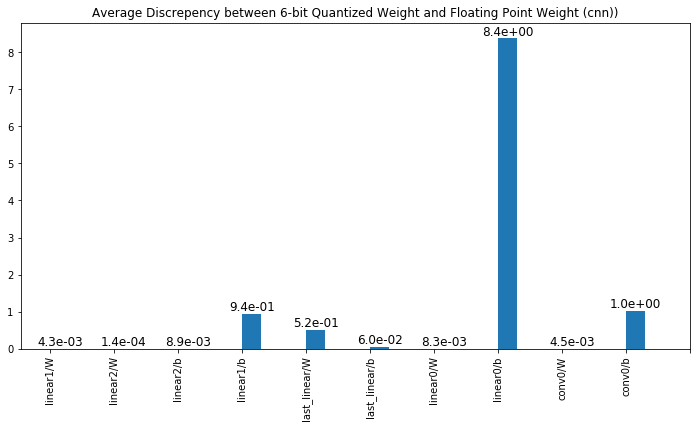

In [12]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(12, 6))

vals,keys=magnitude_discrepencies_quant,model_vars   
bar = plt.bar(range(len(vals)), vals, align='edge', width=0.3)
plt.title("Average Discrepency between {}-bit Quantized Weight and Floating Point Weight ({}))".format(w_bits, model_name))
plt.xticks(range(len(keys)), keys, rotation='vertical')
matplotlib.rcParams.update({'font.size': 12})
for rect in bar:
    height = rect.get_height()
    print("{:.2e}".format(height))
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "{:.1e}".format(height), ha='center', va='bottom')

plt.show()
plt.savefig('discrepency_{}.png'.format(model_name))

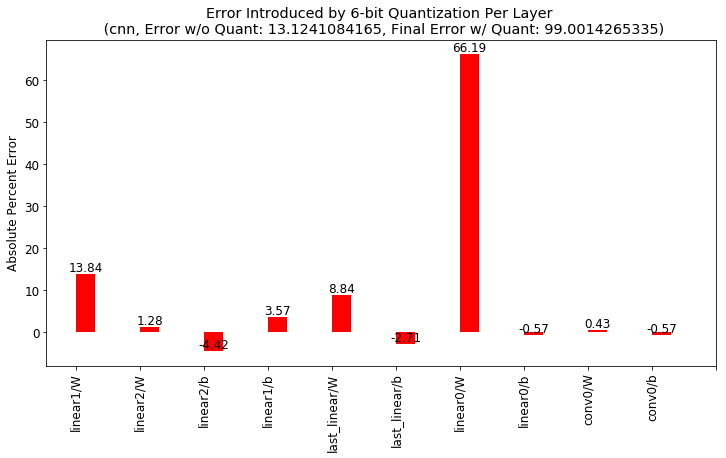

In [14]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(12, 6))

vals = errors_after_quantizing_each_layer
vals = [vals[i+1] - vals[i] for i,v in enumerate(vals[:-1])]
vals=[v*100 for v in vals]
keys=model_vars

# move last linear to back

bar = plt.bar(range(len(vals)), vals, align='edge', width=0.3, color='red')
plt.title("Error Introduced by {}-bit Quantization Per Layer \n ({}, Error w/o Quant: {}, Final Error w/ Quant: {})".format(w_bits, model_name, errors_after_quantizing_each_layer[0]*100,errors_after_quantizing_each_layer[-1]*100))
plt.xticks(range(len(keys)), keys, rotation='vertical')
plt.ylabel("Absolute Percent Error")
matplotlib.rcParams.update({'font.size': 12})
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "{0:.2f}".format(height), ha='center', va='bottom')

plt.show()
plt.savefig('errors_{}.png'.format(model_name))